In [1]:
from torchvision.models import vgg16
import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import VOCDetection
import torch.optim as optim
import PIL.Image as Image
import PIL.ImageColor as ImageColor
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
import imageio
import math
from torchvision.transforms import Resize
import matplotlib.pyplot as plt
import numpy as np
from easydict import EasyDict as edict
import tensorflow as tf
from IPython import display
import random

In [2]:
import matplotlib.font_manager as fm # to create font

In [3]:
fontsize = 24
FONT = ImageFont.truetype(fm.findfont(fm.FontProperties(family='DejaVu Sans')),fontsize)
vgg16=vgg16(pretrained=True).to('cuda')
vgg16=vgg16.features[0:24]

In [4]:
vgg16[1]=nn.ReLU(inplace=False)
vgg16[3]=nn.ReLU(inplace=False)
vgg16[6]=nn.ReLU(inplace=False)
vgg16[8]=nn.ReLU(inplace=False)
vgg16[11]=nn.ReLU(inplace=False)
vgg16[13]=nn.ReLU(inplace=False)
vgg16[15]=nn.ReLU(inplace=False)
vgg16[18]=nn.ReLU(inplace=False)
vgg16[20]=nn.ReLU(inplace=False)
vgg16[22]=nn.ReLU(inplace=False)

In [5]:
class generate_anchors(nn.Module):
    def __init__(self,base_size=16,rations=torch.tensor([0.5,1,2]).to('cuda'),scales=2**torch.arange(3,6).to('cuda')):
        super(generate_anchors,self).__init__()
        
        self.base=torch.tensor([0,0,15,15],device='cuda')
        self.base_size=base_size
        self.rations=rations
        self.scales=scales
        

    def get_center(self,anchors):
        
        h=anchors[3]-anchors[1]+1
        w=anchors[2]-anchors[0]+1
        
        x_ctr=(anchors[0]+anchors[2])/2
        y_ctr=(anchors[1]+anchors[3])/2
        
        return h,w,x_ctr,y_ctr
    
    def change_on_rations(self,sizes):
        
        h,w,x_ctr,y_ctr=self.get_center(self.base)
        
        sizes=sizes.unsqueeze(1)
        
        ws=torch.sqrt(sizes/self.rations)
        
        
        hs=sizes/ws
        
        ws=ws.reshape(-1,1)
        hs=hs.reshape(-1,1)
        
        
        
        anchors=torch.hstack((torch.round(torch.ones_like(ws)*x_ctr-(ws-1)*0.5),torch.round(torch.ones_like(hs)*y_ctr-(hs-1)*0.5),
                            torch.round(torch.ones_like(ws)*x_ctr+(ws-1)*0.5),torch.round(torch.ones_like(hs)*y_ctr+(hs-1)*0.5)))
        
        return anchors
    
    def change_on_scales(self):
        
        h,w,x_ctr,y_ctr=self.get_center(self.base)
        
        sizes=h*w*self.scales*self.scales
        
        anchors=self.change_on_rations(sizes)
        
        return anchors
    
    def forward(self,height,width,feat_stride):
        
        anchors=self.change_on_scales()
        
        A=anchors.shape[0]
        
        shift_x=(torch.arange(width)*feat_stride).to('cuda')
        shift_y=(torch.arange(height)*feat_stride).to('cuda')
        
        shift_x,shift_y=torch.meshgrid(shift_x,shift_y)
        shift_x=shift_x.reshape(-1,1).to('cuda')
        shift_y=shift_y.reshape(-1,1).to('cuda')
        shifts=torch.hstack((shift_x,shift_y,shift_x,shift_y))
        K=shifts.shape[0]
        
        shifts=shifts.reshape(1,K,4).permute((1,0,2))
        anchors=anchors.reshape(1,A,4)
        anchors=anchors+shifts
        
        anchors=anchors.reshape(A*K,4)
        length=A*K
        
        return anchors,length
        

In [6]:
class proposal_layers(nn.Module):
    
    def __init__(self,rpn_cls_prod,rpn_bbox_pred,anchors):
        super(proposal_layers,self).__init__()
        
        self.rpn_cls_prod=rpn_cls_prod#(1,18,60,40)
        self.rpn_bbox_pred=rpn_bbox_pred#(1,36,60,40)
        self.anchors=anchors
        
    def forward(self,im_shape):
        pre_nms_topN=12000
        scores=self.rpn_cls_prod[:,9:,:,:]
        scores=scores.reshape(-1,1)
        self.rpn_bbox_pred=self.rpn_bbox_pred.reshape(-1,4)
        proposals=tools.change_on_pre(self.anchors,self.rpn_bbox_pred)
        proposals=tools.clip_boxes(proposals,im_shape)
        scores=torch.squeeze(scores)
        orders=(-1*scores).argsort()
        
        #选择前几位
        orders=orders[:pre_nms_topN]
        orders=torch.squeeze(orders)
        proposals=proposals[orders,:]

        scores=scores[orders]

        keeps=tools.nms(proposals,scores)
        keeps=keeps[:2000]
        
        proposals=proposals[keeps,:]
        scores=scores[keeps]
        
        return proposals,scores

In [7]:
class public_tools(nn.Module):
    
    def __init__(self):
        super(public_tools,self).__init__()
        
    def change_on_pre(self,anchors,rpn_bbox_pred):
        
        ws=anchors[:,2]-anchors[:,0]+1
        hs=anchors[:,3]-anchors[:,1]+1
        ws=ws.unsqueeze(1)
        hs=hs.unsqueeze(1)
        x_ctr=(anchors[:,0]+anchors[:,2])/2
        y_ctr=(anchors[:,1]+anchors[:,3])/2
        x_ctr=x_ctr.unsqueeze(1)
        y_ctr=y_ctr.unsqueeze(1)
        
        dx=rpn_bbox_pred[:,0].unsqueeze(1)
        dy=rpn_bbox_pred[:,1].unsqueeze(1)
        dw=rpn_bbox_pred[:,2].unsqueeze(1)
        dh=rpn_bbox_pred[:,3].unsqueeze(1)
        
        pred_ctr_x=dx*ws+x_ctr
        pred_ctr_y=dy*hs+y_ctr
        pred_w=torch.exp(dw)*ws
        pred_h=torch.exp(dh)*hs
        pred_box=torch.zeros_like(rpn_bbox_pred,device='cuda')
        
        pred_box[:,0]=torch.squeeze(pred_ctr_x-0.5*pred_w).clone().detach()
        pred_box[:,1]=torch.squeeze(pred_ctr_y-0.5*pred_h).clone().detach()
        pred_box[:,2]=torch.squeeze(pred_ctr_x+0.5*pred_w).clone().detach()
        pred_box[:,3]=torch.squeeze(pred_ctr_y+0.5*pred_h).clone().detach()
        
        return pred_box
    def clip_boxes(self,proposals,im_shape):
        proposals[:,0]=torch.maximum(torch.minimum(proposals[:,0],torch.tensor(im_shape[1]-1,device='cuda')),torch.tensor(0,device='cuda')).clone().detach()
        proposals[:,1]=torch.maximum(torch.minimum(proposals[:,1],torch.tensor(im_shape[0]-1,device='cuda')),torch.tensor(0,device='cuda')).clone().detach()
        proposals[:,2]=torch.maximum(torch.minimum(proposals[:,2],torch.tensor(im_shape[1]-1,device='cuda')),torch.tensor(0,device='cuda')).clone().detach()
        proposals[:,3]=torch.maximum(torch.minimum(proposals[:,3],torch.tensor(im_shape[0]-1,device='cuda')),torch.tensor(0,device='cuda')).clone().detach()
        
        return proposals
        
    def nms(self,proposals,scores,Threshold=0.7):
        
        
        x1=proposals[:,0]
        y1=proposals[:,1]
        x2=proposals[:,2]
        y2=proposals[:,3]
        
        areas=(y2-y1+1)*(x2-x1+1)
        scores=torch.squeeze(scores)
        orders=(-1*scores).argsort()
        keep=[]
        if len(orders)==0:
            pass
        else:
            while orders.size()[0]>0:

                i=orders[0]

                keep.append(i)

                xx1=torch.maximum(x1[i],x1[orders[1:]])
                yy1=torch.maximum(y1[i],y1[orders[1:]])
                xx2=torch.minimum(x2[i],x2[orders[1:]])
                yy2=torch.minimum(y2[i],y2[orders[1:]])

                ws=torch.maximum(xx2-xx1+1,torch.tensor(0).to('cuda'))
                hs=torch.maximum(yy2-yy1+1,torch.tensor(0).to('cuda'))

                inter=ws*hs
                iou=inter/(areas[i]+areas[orders[1:]]-inter)

                index=torch.where(iou<Threshold)[0]

                orders=orders[index+1]

            keep=torch.tensor(keep,device='cuda')

            return keep
    
    def bbox_overlaps(self,anchors,gt_boxes):
        
        N,M=anchors.shape
        K,M=gt_boxes.shape
        
        overlaps=torch.zeros(N,K,device='cuda')
        
        for k in range(K):
            
            area_gt=(gt_boxes[k,2]-gt_boxes[k,0]+1)*(gt_boxes[k,3]-gt_boxes[k,1]+1)
            
            xx1=torch.maximum(gt_boxes[k,0],anchors[:,0])
            yy1=torch.maximum(gt_boxes[k,1],anchors[:,1])
            xx2=torch.minimum(gt_boxes[k,2],anchors[:,2])
            yy2=torch.minimum(gt_boxes[k,3],anchors[:,3])
            hs=torch.maximum(torch.tensor(0,device='cuda'),yy2-yy1+1)
            ws=torch.maximum(torch.tensor(0,device='cuda'),xx2-xx1+1)
            areas=hs*ws
            an_areas=(anchors[:,2]-anchors[:,0]+1)*(anchors[:,3]-anchors[:,1]+1)
            
            iou=areas/(area_gt+an_areas-areas)
            
            overlaps[:,k]=iou.clone().detach().to('cuda')
        return overlaps
    
    def computer_targets(self,anchors,gt_box):
        
        an_ws=anchors[:,2]-anchors[:,0]+1
        an_hs=anchors[:,3]-anchors[:,1]+1
        ctr_x=(anchors[:,0]+anchors[:,2])/2
        ctr_y=(anchors[:,1]+anchors[:,3])/2
        
        gt_ws=gt_box[:,2]-gt_box[:,0]+1
        gt_hs=gt_box[:,3]-gt_box[:,1]+1
        gt_ctr_x=(gt_box[:,0]+gt_box[:,2])/2
        gt_ctr_y=(gt_box[:,1]+gt_box[:,3])/2
        
        targets_dx=(gt_ctr_x-ctr_x)/an_ws
        targets_dy=(gt_ctr_y-ctr_y)/an_hs
        targets_dw=torch.log(gt_ws/an_ws)
        targets_dh=torch.log(gt_hs/an_hs)
        
        targets=torch.vstack((targets_dx,targets_dy,targets_dw,targets_dh)).T
        
        return targets
    
    def unmap(self,data,alls_num,inds,fill=0):
        data=data.type(torch.float64)
        if len(data.shape)==1:
            
            ret=torch.empty(alls_num,dtype=torch.float64).to('cuda')
            ret.fill_(fill)
            ret[inds]=data.clone().detach()
            
        else:
            
            ret=torch.empty(alls_num,data.shape[1],dtype=torch.float64).to('cuda')
            ret.fill_(fill)
        
            ret[inds,:]=data.clone().detach()
        return ret
        
    def get_bbox_regression_labels(self,bbox_target_data, num_classes,clss):
        
        box_targets=torch.zeros(len(clss),4*num_classes,device='cuda')
        box_inside_weights=torch.zeros(box_targets.shape,device='cuda')
        
        inds=torch.where(clss>0)[0]
        for ind in inds:
            cls=clss[ind]
            
            strat=int(4*cls)
            end=strat+4
            #inplace=bbox_target_data[ind]
            box_targets[ind,strat:end]=bbox_target_data[ind].clone().detach()
            box_inside_weights[ind,strat:end]=torch.tensor([1,1,1,1],device='cuda')
            
        return box_targets,box_inside_weights
        
        
    def sample_rois(self,all_rois, all_scores, gt_boxes,gt_labels, fg_rois_per_image,rois_per_image, num_classes):
        
        overlaps=self.bbox_overlaps(all_rois,gt_boxes)
        gt_argmax=overlaps.argmax(axis=1)
        
        max_overlaps=overlaps[torch.arange(len(overlaps)),gt_argmax]
        labels=gt_labels[gt_argmax]
        fg_inds=torch.where(max_overlaps>=0.6)[0]
        bg_inds=torch.where((max_overlaps>0.2)&(max_overlaps<0.6))[0]
        if (len(bg_inds)==0)&(len(fg_inds)==0):
            bg_inds=torch.where((max_overlaps<0.5) & (max_overlaps>0))[0]
        if fg_inds.size()[0]>0 and bg_inds.size()[0]>0:
            
            fg_rois_per_image=torch.min(torch.tensor(fg_rois_per_image,device='cuda'),
                           torch.tensor(fg_inds.size()[0],device='cuda'))
            fg_inds=np.array(fg_inds.to('cpu'))
            fg_inds=np.random.choice(fg_inds,int(fg_rois_per_image),replace=False)
            fg_inds=torch.from_numpy(fg_inds).to('cuda')
            
            bg_rois_per_image=rois_per_image-fg_rois_per_image
            to_replace=bg_inds.size()[0]<bg_rois_per_image
            bg_inds=np.array(bg_inds.to('cpu'))
            bg_inds=np.random.choice(bg_inds,int(bg_rois_per_image),replace=to_replace)
            bg_inds=torch.from_numpy(bg_inds).to('cuda')
            
            
        if (fg_inds.size()[0]>0) and (bg_inds.size()[0])==0:
            
            to_replace=fg_inds.size()[0]<rois_per_image
            
            fg_inds=np.array(fg_inds.to('cpu'))
            fg_inds=np.random.choice(fg_inds,int(rois_per_image),replace=to_replace)
            fg_inds=torch.from_numpy(fg_inds).to('cuda')
            fg_rois_per_image=rois_per_image
            
        if (bg_inds.size()[0]>0) and (fg_inds.size()[0]==0):
            
            to_replace=bg_inds.size()[0]<rois_per_image
            
            bg_inds=np.array(bg_inds.to('cpu'))
            bg_inds=np.random.choice(bg_inds,int(rois_per_image),replace=to_replace)
            bg_inds=torch.from_numpy(bg_inds).to('cuda')
            fg_rois_per_image=0
       # else:
       #     import pdb
       #     pdb.set_trace()
        fg_inds=fg_inds
        bg_inds=bg_inds
        keep_inds=torch.hstack((fg_inds,bg_inds))
        labels=labels[keep_inds]

        labels[int(fg_rois_per_image):]=0
        rois=all_rois[keep_inds]
        rois_scores=all_scores[keep_inds]
        box_target_data=self.computer_targets(rois,gt_boxes[gt_argmax[keep_inds],:])
        
        box_targets,box_inside_weight=self.get_bbox_regression_labels(box_target_data,num_classes,labels)
        
        return labels,rois,rois_scores,box_targets,box_inside_weight

In [8]:
tools=public_tools()

In [9]:
class anchor_target_layer(nn.Module):
    '''
    第一层监督
    '''
    def __init__(self,rpn_cls_score, gt_boxes, im_shape, all_anchors,_feat_stride, num_anchors):
        
        super(anchor_target_layer,self).__init__()
        self.rpn_cls_score=rpn_cls_score
        self.gt_boxes=gt_boxes
        self.im_shape=im_shape
        
        self._feat_stride=_feat_stride
        self.all_anchors=all_anchors
        self.num_anchors=num_anchors
        
    def forward(self):
        
        n,c,height,width=self.rpn_cls_score.shape
        
        M,K=self.gt_boxes.shape
        all_num,l=self.all_anchors.shape
        indexs=torch.where((self.all_anchors[:,0]>=0)&(self.all_anchors[:,1]>=0)&
                           (self.all_anchors[:,2]<=self.im_shape[1])&(self.all_anchors[:,3]<=self.im_shape[0]))[0]
        anchors=self.all_anchors[indexs]
        labels=-1*torch.ones_like(indexs,device='cuda')
        
        overlaps=tools.bbox_overlaps(anchors,self.gt_boxes)#(N,K)
        
        argmax_overlaps=overlaps.argmax(axis=1)#(N,1)
        max_overlaps=overlaps[torch.arange(len(indexs)),argmax_overlaps]

        gt_argmax_overlaps=overlaps.argmax(axis=0)
        gt_max_overlaps=overlaps[gt_argmax_overlaps,torch.arange(overlaps.shape[1])]
        #gt_argmax_overlaps=torch.where(overlaps==gt_max_overlaps)[0]
        labels[max_overlaps<0.3]=0
        labels[gt_argmax_overlaps]=1
        labels[max_overlaps>0.7]=1
        
      
        #防止positive过多
        
        num_fg=128
        fg_inds=torch.where(labels==1)[0]
        if len(fg_inds)>num_fg:
            
            fg_inds=np.array(fg_inds.to('cpu'))
            dis_able=np.random.choice(fg_inds,len(fg_inds)-num_fg,replace=False)
            dis_able=torch.from_numpy(dis_able).to('cuda')
            
            labels[dis_able]=-1
            
      
        num_bg=256-torch.sum(labels==1)
        bg_inds=torch.where(labels==0)[0]
        if len(bg_inds)>num_bg:
            
            bg_inds=np.array(bg_inds.to('cpu'))
            num=len(bg_inds)-num_bg
            num=np.array(num.to('cpu'))
            dis_able=np.random.choice(bg_inds,num,replace=False)
            dis_able=torch.from_numpy(dis_able).to('cuda')
            labels[dis_able]=-1
            
        box_targets=tools.computer_targets(anchors,self.gt_boxes[argmax_overlaps,:])
        
        #权重
        box_inside_weights=torch.zeros(len(indexs),4,dtype=torch.float64,device='cuda')
        box_inside_weights[labels==1,:]=torch.tensor([1,1,1,1],dtype=torch.float64,device='cuda')
        
        box_outside_weights=torch.zeros(len(indexs),4,dtype=torch.float64,device='cuda')
        num_example=torch.sum(labels>=0)
        
        pos_weight=torch.tensor([1,1,1,1],dtype=torch.float64,device='cuda')/num_example
        neg_weight=torch.tensor([1,1,1,1],dtype=torch.float64,device='cuda')/num_example
        
        box_outside_weights[labels==1,:]=pos_weight
        box_outside_weights[labels==0,:]=neg_weight
        
        labels=labels.type(torch.float64)
        labels=tools.unmap(labels,all_num,indexs,fill=-1)
        box_targets=tools.unmap(box_targets,all_num,indexs,fill=0)
        box_inside_weights=tools.unmap(box_inside_weights,all_num,indexs,fill=0)
        box_outside_weights=tools.unmap(box_outside_weights,all_num,indexs,fill=0)
        
        labels=labels.reshape(1,1,self.num_anchors*height,width)
        rpn_labels=labels
        
        rpn_box_targets=box_targets.reshape(1,self.num_anchors*4,height,width)
        rpn_box_inside_weights=box_inside_weights.reshape(1,self.num_anchors*4,height,width)
        rpn_box_outside_weights=box_outside_weights.reshape(1,self.num_anchors*4,height,width)
        return rpn_labels,rpn_box_targets,rpn_box_inside_weights,rpn_box_outside_weights
      

In [10]:
class proposal_target_layer(nn.Module):
    """
    第二层监督
    """
    def __init__(self,rpn_rois, rpn_scores, gt_boxes, _num_classes):
        
        super(proposal_target_layer,self).__init__()
        
        self.rpn_rois=rpn_rois
        self.rpn_scores=rpn_scores
        self.gt_boxes=gt_boxes
        self.num_class=_num_classes
    def forward(self):
        
        all_rois = self.rpn_rois
        all_scores = self.rpn_scores
        rois_per_image=128
        fg_rois_per_image=32
        
        labels, rois, roi_scores, box_targets, box_inside_weights=tools.sample_rois(
            all_rois,all_scores,self.gt_boxes[:,0:-1],self.gt_boxes[:,-1],fg_rois_per_image,rois_per_image,self.num_class)
        
        rois=rois.reshape(-1,4)

        roi_scores=roi_scores.reshape(-1,1)
        labels=labels.reshape(-1,1)
        box_targets=box_targets.reshape(-1,4*self.num_class)
        box_inside_weights=box_inside_weights.reshape(-1,4*self.num_class)
        box_outside_weights=(box_inside_weights>0).clone().detach()
        
        return rois,roi_scores,labels,box_targets,box_inside_weights,box_outside_weights
        

In [11]:
class faster_rcnn(nn.Module):
    
    def __init__(self,num_anchors,num_class):
        super(faster_rcnn,self).__init__()
        
        self.add_module("vgg",vgg16)
        self.num_anchors=num_anchors
        self.num_class=num_class
        
        self.layer1=nn.Conv2d(512,512,kernel_size=3,padding=1,stride=1)
        self.relu1=nn.ReLU(inplace=False)
        
        self.cls_score_layer=nn.Conv2d(512,num_anchors*2,kernel_size=1,padding=0,stride=1)
        self.cls_score_relu=nn.ReLU(inplace=False)
        
        self.layer2=nn.Conv2d(512,num_anchors*4,kernel_size=1,padding=0,stride=1)
        self.relu2=nn.ReLU(inplace=False)
        
        self.lina=nn.Linear(32768,4096)
        self.linb=nn.Linear(4096,4096)
        self.ra=nn.ReLU()
        self.rb=nn.ReLU()
        self.lin1=nn.Linear(4096,21)
        self.lin2=nn.Linear(4096,21*4)
    def reshape_layers(self,rpn_cls_score,dim):
        
        n,c,h,w=rpn_cls_score.shape
        rpn_cls_score=rpn_cls_score.reshape(n,dim,-1,w)
        
        return rpn_cls_score
        
    def softmax(self,reshape_rpn_cls_score):
        
        rpn_cls_prob_reshape=nn.Softmax(dim=1)(reshape_rpn_cls_score)
        
        return rpn_cls_prob_reshape
    def crop_pool_layer(self,net_conv,rois,feat_stride=16):
        
        '''
        裁剪pooling
        '''
        n,c,height,width=net_conv.shape
        height=(height)*feat_stride
        width=(width)*feat_stride
        
        x1=(rois[:,0]/width).unsqueeze(1)
        y1=(rois[:,1]/height).unsqueeze(1)
        x2=(rois[:,2]/width).unsqueeze(1)
        y2=(rois[:,3]/height).unsqueeze(1)
        
        num=len(x1)
        
        
        bboxes=tf.constant(torch.hstack((y1,x1,y2,x2)).to('cpu').detach().numpy())
        net_conv=net_conv.permute(0,2,3,1)
        net_conv=tf.constant(net_conv.to('cpu').detach().numpy())
        crops=tf.image.crop_and_resize(net_conv,bboxes,tf.zeros(num,dtype=tf.int32),[14,14])
        crops=torch.tensor(crops.numpy(),device='cuda')
        crops=crops.permute(0,3,1,2)
        crops=torch.nn.MaxPool2d(kernel_size=[2,2],stride=2,padding=1)(crops)
        #if hasattr(torch.cuda, 'empty_cache'):
         #   torch.cuda.empty_cache()

        #crops=torch.tensor(crops.numpy(),device='cuda')
        #crops=crops.permute(0,3,1,2)
        return crops
        
        
    def classification(self,pool5,num):
        
        x=self.lina(pool5)
        x=self.ra(x)
        x=self.linb(x)
        x=self.rb(x)
        cls_score=self.lin1(x)
        
        cls_prod=self.softmax(cls_score)
        cls_pred=torch.argmax(cls_prod,axis=1)
        
        box_pred=self.lin2(x)
        
        return cls_prod,box_pred,cls_score
        
    def get_final(self,rois,scores):
    
        indexs=(-1*scores).argsort()

        indexs=indexs[0:1000]

        rois=rois[0:1000,:]

        return rois
        
    def forward(self,image,gt_box=None,is_training=True):
        
        list_c=[]
        list_r=[]
        n1,c1,h1,w1=image.shape
        net_conv=self.vgg(image)
        
        n,c,height,width=net_conv.shape
        im_shape=[h1,w1]
        all_anchors,length=generate_anchors()(height,width,feat_stride=16)
        rpn=self.layer1(net_conv)
        rpn=self.relu1(rpn)
        
        
        #类别预测
        rpn_cls_score=self.cls_score_layer(rpn)
        rpn_cls_score=self.cls_score_relu(rpn_cls_score) #(1,18,60,40)#(512,14,14)
        reshape_rpn_cls_score=self.reshape_layers(rpn_cls_score,dim=2)
        
        rpn_cls_prod_reshape=self.softmax(reshape_rpn_cls_score)
        
        rpn_cls_pred=torch.argmax(rpn_cls_prod_reshape.reshape(-1,2),axis=1)
        
        rpn_cls_prod=self.reshape_layers(rpn_cls_prod_reshape,dim=self.num_anchors*2)#(1,18,60,40)
        
        #边框targets预测

        rpn_bbox_pred=self.layer2(rpn)
        #rpn_bbox_pred=self.relu2(rpn_bbox_pred)#(1,36,60,40)
        
        if is_training:
            rpn_labels,rpn_box_targets,rpn_box_inside_weights,rpn_box_outside_weights=anchor_target_layer(rpn_cls_score,gt_box,im_shape,
                                         all_anchors, _feat_stride=16,num_anchors=9)()
            list_r=[rpn_labels,rpn_box_targets,rpn_box_inside_weights,rpn_box_outside_weights]
            rois,rios_scores=proposal_layers(rpn_cls_prod,rpn_bbox_pred,all_anchors)([h1,w1])
            rois, roi_scores, labels, bbox_targets, bbox_inside_weights, bbox_outside_weights=proposal_target_layer(
                rois,rios_scores,gt_box,self.num_class)()
            list_c=[roi_scores, labels, bbox_targets, bbox_inside_weights, bbox_outside_weights]
            
            
            
            pool5=self.crop_pool_layer(net_conv,rois)

        
            p_n,p_c,p_h,p_w=pool5.shape
            num=p_c*p_h*p_w
            pool5=torch.reshape(pool5,(p_n,-1))

            cls_prod,box_pred,cls_scores=self.classification(pool5,num)
            #cls_prod=self.softmax(cls_prod)
            return list_c,list_r,cls_prod,box_pred,rpn_cls_score,rpn_bbox_pred,rois,cls_scores
        else:
            rois,rios_scores=proposal_layers(rpn_cls_prod,rpn_bbox_pred,all_anchors)([h1,w1])
            rois=self.get_final(rois,rios_scores)
            
            pool5=self.crop_pool_layer(net_conv,rois)
            p_n,p_c,p_h,p_w=pool5.shape
            num=p_c*p_h*p_w
            pool5=torch.reshape(pool5,(p_n,-1))

            cls_prod,box_pred,cls_scores=self.classification(pool5,num)
            #cls_prod=self.softmax(cls_prod)
            return cls_prod,box_pred,rois,cls_scores

In [12]:
class rcnn_loss(nn.Module):
    def __init__(self,list_r,list_c,cls_prod,box_pred,rpn_cls_prod,rpn_bbox_pred):
        
        super(rcnn_loss,self).__init__()
        #第二次监督
        self.list_c=list_c
        self.cls_prod=cls_prod
        self.box_pred=box_pred
        
        #第一次监督
        self.list_r=list_r
        self.rpn_cls_prod=rpn_cls_prod
        self.rpn_bbox_pred=rpn_bbox_pred
    
    def smooth_l1_loss(self, bbox_pred, bbox_targets, bbox_inside_weights, bbox_outside_weights, sigma=1.0,dim=[1]):
        
        box_diff=bbox_pred-bbox_targets
        in_box_diff=box_diff*bbox_inside_weights
        abs_in_box_diff=torch.abs(in_box_diff)
        smoothL1_sign1=torch.less(abs_in_box_diff,1).detach()
        
        smoothL1_sign=torch.zeros_like(smoothL1_sign1,dtype=torch.float64)
        smoothL1_sign[smoothL1_sign1]=1
        in_loss_box1=torch.pow(in_box_diff,2)*(1/2)*smoothL1_sign+(abs_in_box_diff-0.5)*(1-smoothL1_sign)
        
        out_loss_box=bbox_outside_weights*in_loss_box1
        loss_box=torch.mean(torch.sum(out_loss_box,axis=dim,dtype=torch.float64))
        
        return loss_box
    
    
    def rpn_class_loss(self):
        rpn_labels=self.list_r[0].reshape(-1,)
        rpn_cls_score=self.rpn_cls_prod.reshape(2,-1)[1,:]
        rpn_select=torch.where(torch.not_equal(rpn_labels,-1))[0]
        rpn_cls_score=rpn_cls_score[rpn_select]
        rpn_labels=rpn_labels[rpn_select]
        rpn_class_loss1=torch.nn.BCEWithLogitsLoss()(rpn_cls_score,rpn_labels)
        return rpn_class_loss1
    

    def rpn_box_loss(self):
        rpn_box_targets,rpn_box_inside_weights,rpn_box_outside_weights=self.list_r[1],self.list_r[2],self.list_r[3]
        rpn_box_loss1=self.smooth_l1_loss(self.rpn_bbox_pred,
                                          rpn_box_targets,rpn_box_inside_weights,rpn_box_outside_weights,sigma=3,dim=[1, 2, 3])
        return rpn_box_loss1
    
    def rcnn_box_loss(self):
        
        box_targets,box_inside_weight,box_outside_weight=self.list_c[2],self.list_c[3],self.list_c[4]
        rcnn_box_loss1=self.smooth_l1_loss(self.box_pred,box_targets,box_inside_weight,box_outside_weight)
        
        return rcnn_box_loss1
    
    def rcnn_class_loss(self):
        
        labels=self.list_c[1]
        label=torch.zeros_like(self.cls_prod,dtype=torch.float64)
        label[torch.arange(len(label)),torch.squeeze(labels)]=1
        
        index1=torch.where(label[:,0]==0)[0]
        index2=torch.where(label[:,0]!=0)[0]
        len1=len(index1)
        len2=len(index2)
        loss1=torch.nn.BCEWithLogitsLoss()(self.cls_prod[index1,:],label[index1,:])
        loss2=torch.nn.BCEWithLogitsLoss()(self.cls_prod[index2,:],label[index2,:])
        rcnn_class_loss1=4*loss1+loss2
        
        return rcnn_class_loss1
    
    
    def forward(self):
        
        #print(self.rpn_class_loss(),self.rpn_box_loss(),self.rcnn_class_loss(),self.rcnn_box_loss())
        loss=self.rpn_class_loss()+self.rpn_box_loss()+self.rcnn_class_loss()+4*self.rcnn_box_loss()
        
        return loss

In [13]:
def draw_one(images,xmin,ymin,xmax,ymax,display_str,font,color='red',thickness=1):
        
    draw = ImageDraw.Draw(images)
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
    draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)
    text_bottom = top
    text_width, text_height = font.getsize(display_str)
    #print(text_width,text_height)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle(
      [(left, text_bottom - text_height - 2 * margin), (left + text_width,
                                                        text_bottom)],
      fill=color)
    draw.text(
      (left + margin, text_bottom - text_height - margin),
      display_str,
      fill='black',
      font=font)

    return images
def draw_it(image,labels,box):
    
    num_box=box.size()[0]
    image=torch.squeeze(image)
    image=image.permute(1,2,0)
    image=image.to('cpu').numpy()
    image=np.round((image*0.5+0.5)*255)
    image=image.astype(np.uint8)
    image=Image.fromarray(image)
    for i in range(num_box):
        the_class=labels[i]
        xmin,ymin,xmax,ymax=box[i,0],box[i,1],box[i,2],box[i,3]
        image=draw_one(image,xmin,ymin,xmax,ymax,'%s'%(the_class),FONT)
    image=torch.tensor(np.array(image),device='cuda')  
    return image   

In [14]:
net=faster_rcnn(num_anchors=9,num_class=21).to('cuda')
optimizer = optim.Adam(net.parameters(), lr=0.00001) #设置优化器和学习率

In [15]:
net.parameters

<bound method Module.parameters of faster_rcnn(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, 

In [16]:
def get_best(name,scores,proposals):
    Threshold=0.4
    x1=proposals[:,0]
    y1=proposals[:,1]
    x2=proposals[:,2]
    y2=proposals[:,3]

    areas=(y2-y1+1)*(x2-x1+1)
    scores=torch.squeeze(scores)
    orders=(-1*scores).argsort()
    keep=[]
    while orders.size()[0]>0:

        i=orders[0]

        keep.append(i)

        xx1=torch.maximum(x1[i],x1[orders[1:]])
        yy1=torch.maximum(y1[i],y1[orders[1:]])
        xx2=torch.minimum(x2[i],x2[orders[1:]])
        yy2=torch.minimum(y2[i],y2[orders[1:]])

        ws=torch.maximum(xx2-xx1+1,torch.tensor(0,device='cuda'))
        hs=torch.maximum(yy2-yy1+1,torch.tensor(0,device='cuda'))

        inter=ws*hs
        iou=inter/(areas[i]+areas[orders[1:]]-inter)

        index=torch.where(iou<Threshold)[0]

        orders=orders[index+1]
    
    keep=torch.tensor(keep,device='cuda')
    proposals=proposals[keep,:]
    name=name[keep]
    return proposals,name


In [17]:
def train_rcnn(epoches,images,datasets):
    
    length=len(datasets)
    net.train()
    for i_2 in range(epoches):
        num=0
        for j in range(len(images)-100):

            print("epocges:%d    "%(i_2),"num:%d    "%(j),end="\r")
            optimizer.zero_grad()
            image=images[j].to('cuda')
            image=image.unsqueeze(0)
            n1,c1,h1,w1=image.size()
            gt_box=torch.tensor(datasets[j],device='cuda')
            #image = image.to(device)
           # gt_box = gt_box.to(device)
            list_c,list_r,cls_prod,box_pred,rpn_cls_prod,rpn_bbox_pred ,rois,cls_scores=net(image,gt_box)
            loss=rcnn_loss(list_r,list_c,cls_scores,box_pred,rpn_cls_prod,rpn_bbox_pred)()
           # torch.autograd.set_detect_anomaly(True)
            loss.backward()
            optimizer.step()
           # torch.cuda.empty_cache()
            if j%100==1:
                """
                测试一张图片
                """
                test_num=random.randint(2400,2498)
                #test_num=j
                image=images[test_num].to('cuda')
                image=image.unsqueeze(0)
                n1,c1,h1,w1=image.size()
                gt_box=torch.tensor(datasets[test_num],device='cuda')
                cls_prod,box_pred,rois,cls_scores=net(image,is_training=False)
                #print(box_pred.shape)
                cls_prod=cls_scores
                index1=cls_prod.argmax(axis=1)
                box_pred2=torch.zeros_like(box_pred[:,0:4],device='cuda')
                for i in range(len(box_pred2)):
                    box_pred2[i]=box_pred[i,index1[i]*4:4*index1[i]+4]
                cls_prod=cls_prod[torch.arange(len(index1)),index1]
                index2=torch.where(cls_prod>0.9)[0]
                #cls_prod=torch.round(cls_prod[index2]).type(torch.int)
                cls_prod=index1[index2].type(torch.int)
                index3=torch.where(cls_prod!=0)[0]
                cls_prod=cls_prod[index3]
                if len(index2)<=1 or len(index3)<=1:
                    pass
                else:
                    display.clear_output(wait=True)

                    boxes=tools.change_on_pre(rois,box_pred2)[index2,:]
                    #boxes=rois[index2,:]
                    boxes=boxes[index3,:]
                    boxes=tools.clip_boxes(boxes,[h1,w1])
                    #boxes=tools.nms(boxes,cls_prod,0.6)
                    list_name=[]
                    for i in range(len(cls_prod)):
                        list_name.append(cls_prod[i])
                        
                        
                    list_name=torch.tensor(list_name,device='cuda')
                    
                    boxes,names=get_best(list_name,cls_prod,boxes)
                    list_name=[]
                    
                    for i in range(len(names)):
                        list_name.append(name[names[i]])
                    boxes=torch.round(boxes).type(torch.int)
                    #print([len(index3),len(boxes)])
                    image=draw_it(image,list_name,boxes)
                    image=torch.squeeze(image.to('cpu'))
                    plt.imshow(image)
                    plt.show()
            


In [18]:
train_tramforms=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [19]:
train=VOCDetection('C:/数据/目标检测voc2007/',year='2007',image_set='train',download=False,transform=train_tramforms)

In [20]:
def get_coo_image(train):
    data_set=[]
    images=[]
    for i in range(len(train)):
        #label=0
        #if i==707:
         #   pass
        if i in [707,1660]:
            continue
        data=[]
        for j in range(len(train[i][1]['annotation']['object'])):
        
            xmin=int(train[i][1]['annotation']['object'][j]['bndbox']['xmin'])
            ymin=int(train[i][1]['annotation']['object'][j]['bndbox']['ymin'])
            xmax=int(train[i][1]['annotation']['object'][j]['bndbox']['xmax'])
            ymax=int(train[i][1]['annotation']['object'][j]['bndbox']['ymax'])
            name=train[i][1]['annotation']['object'][j]['name']
           # if (xmax-xmin)<150 or (ymax-ymin)<150:
           #     label=1
           #     break
            data.append([xmin,ymin,xmax,ymax,name])
            
       
        image=train[i][0]
       # if label!=1:
        data_set.append(data)
        images.append(image)

        
        
    return data_set,images

In [21]:
datasets1,images1=get_coo_image(train)
name=['nan','cow', 'aeroplane', 'bottle', 'bird', 'motorbike', 'person', 'tvmonitor', 'sofa', 'car', 'boat', 'cat', 'horse', 'train', 'bus', 'bicycle', 'chair', 'dog', 'pottedplant', 'sheep', 'diningtable']

In [22]:
dataset=datasets1

In [23]:
for i in range(len(dataset)):
    for j in range(len(dataset[i])):
        dataset[i][j][-1]=name.index(dataset[i][j][-1])


In [ ]:
train_rcnn(30,images1,dataset)

In [ ]:
torch.save(net, "./faster-rcnn.pt")

In [24]:
net=torch.load("./faster-rcnn.pt")

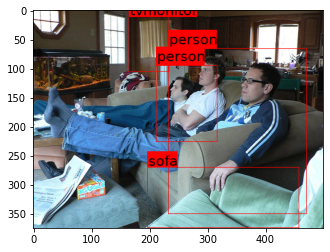

In [38]:
test_num=random.randint(2400,2498)
image=images1[test_num].to('cuda')
image=image.unsqueeze(0)
n1,c1,h1,w1=image.size()
gt_box=torch.tensor(dataset[test_num],device='cuda')
cls_prod,box_pred,rois,cls_scores=net(image,is_training=False)
#print(box_pred.shape)
cls_prod=cls_scores
index1=cls_prod.argmax(axis=1)
box_pred2=torch.zeros_like(box_pred[:,0:4],device='cuda')
for i in range(len(box_pred2)):
    box_pred2[i]=box_pred[i,index1[i]*4:4*index1[i]+4]
cls_prod=cls_prod[torch.arange(len(index1)),index1]
index2=torch.where(cls_prod>0.9)[0]
#cls_prod=torch.round(cls_prod[index2]).type(torch.int)
cls_prod=index1[index2].type(torch.int)
index3=torch.where(cls_prod!=0)[0]
cls_prod=cls_prod[index3]
if len(index2)<=1 or len(index3)<=1:
    pass
else:
    display.clear_output(wait=True)

    boxes=tools.change_on_pre(rois,box_pred2)[index2,:]
    #boxes=rois[index2,:]
    boxes=boxes[index3,:]
    boxes=tools.clip_boxes(boxes,[h1,w1])
    #boxes=tools.nms(boxes,cls_prod,0.6)
    list_name=[]
    for i in range(len(cls_prod)):
        list_name.append(cls_prod[i])


    list_name=torch.tensor(list_name,device='cuda')

    boxes,names=get_best(list_name,cls_prod,boxes)
    list_name=[]

    for i in range(len(names)):
        list_name.append(name[names[i]])
    boxes=torch.round(boxes).type(torch.int)
    #print([len(index3),len(boxes)])
    image=draw_it(image,list_name,boxes)
    image=torch.squeeze(image.to('cpu'))
    plt.imshow(image)
    plt.show()